<h2 style="color:darkblue">IMPLEMENTACIÓN DE LOS MÉTODOS</h2>

<h3 style="color:teal"> OPTIMIZACIÓN CONVEXA</h3>

<h4>Librerías</h4>

In [1]:
# !pip install cvxpy
# !pip install numpy
# !pip install opencv-python
# !pip install tensorflow
# !pip install tabulate

<h4>Funciones para calcular los parámetros que usaremos en nuestro modelo</h4>

In [2]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# Calculamos A para encontrar la luz del aire

def Airlight(HazeImg, windowSize):
    A = []
    for ch in range(len(HazeImg.shape)):
      kernel = np.ones((windowSize, windowSize), np.uint8)
      minImg = cv2.erode(HazeImg[:, :, ch], kernel)
#       plt.imshow(cv2.erode(HazeImg[:, :, ch], kernel))
#       plt.show()
      A.append(int(minImg.max()))
    return(A)

In [3]:
# Calculamos la función de transmisión para cada pixel. La matriz que retornamos 
# es del mismo tamaño de la imagen de entrada y cada elemento tendra un valor entre 0 y 1

def Transmission(HazeImg, A, C0, C1):    
    t_b = np.maximum((A[0] - HazeImg[:, :, 0].astype(float)) / (A[0] - C0),
                      (HazeImg[:, :, 0].astype(float) - A[0]) / (C1 - A[0]))
    t_g = np.maximum((A[1] - HazeImg[:, :, 1].astype(float)) / (A[1] - C0),
                      (HazeImg[:, :, 1].astype(float) - A[1]) / (C1 - A[1]))
    t_r = np.maximum((A[2] - HazeImg[:, :, 2].astype(float)) / (A[2] - C0),
                      (HazeImg[:, :, 2].astype(float) - A[2]) / (C1 - A[2]))
    MaxVal = np.maximum(t_b, t_g, t_r)
    transmission = np.minimum(MaxVal, 1)
    return(transmission)

In [4]:
def plot_results(HazeImg, HazeCorrectedImg):
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
    axes.ravel()
    rgb_img_original = cv2.cvtColor(HazeImg, cv2.COLOR_BGR2RGB)
    rgb_img_dehazed = cv2.cvtColor(HazeCorrectedImg, cv2.COLOR_BGR2RGB)
    axes[0].imshow(rgb_img_original)
    axes[0].title.set_text("Imagen original")
    axes[1].imshow(rgb_img_dehazed)
    axes[1].title.set_text("Imagen reconstruida")
    fig.tight_layout()
    plt.show()

    fig1, axes1 = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    axes1[0].title.set_text("Histograma de colores")
    axes1[0].hist(HazeImg.ravel(),256,[0,256])
    axes1[1].title.set_text("Histograma de colores")
    axes1[1].hist(HazeCorrectedImg.ravel(),256,[0,256])
    fig1.tight_layout()

    fig2, axes2 = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            HazeImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[0].plot(bin_edges[0:-1], histogram, color=color)
    fig2.tight_layout()
    axes2[0].title.set_text("Histograma de colores por canal");    
    axes2[1].title.set_text("Histograma de colores por canal");  

    # fig2.tight_layout()
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            HazeCorrectedImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[1].plot(bin_edges[0:-1], histogram, color=color)

    fig2.tight_layout()
    plt.title("Histograma de colores por canal");


<h4>Construcción del modelo usando CVXPY</h4>

In [5]:
import cvxpy as cp
from cvxpy.atoms.norm1 import norm1
from cvxpy.atoms.pnorm import pnorm
nombre_im="test7."

def removeHaze(HazeImg,Transmission, A, delta, Regularize = False):
    epsilon = 0.0001
    Transmission = pow(np.maximum(abs(Transmission), epsilon), delta)
#     plt.imshow(Transmission,cmap='gray')
#     plt.show()
#     plt.imshow(Transmission-Transmissionn,cmap='gray')
#     plt.show()
    HazeCorrectedImage = copy.deepcopy(HazeImg)
    for ch in range(len(HazeImg.shape)):
        # Definimos los parámetros para construir el modelo en CVXPY
        I_c = cp.Parameter(HazeImg[:, :, ch].shape)
        I_c.value = HazeImg[:, :, ch]        
        t_c = cp.Parameter(Transmission.shape)
        t_c.value = Transmission
        a_c = cp.Parameter()
        a_c.value = A[ch]

        # Definimos la variable a optimizar, que en este caso es la imagen sin niebla que queremos recuperar
        J_c = cp.Variable(HazeCorrectedImage[:, :, ch].shape)
        J_c.value = HazeCorrectedImage[:, :, ch]

        # Si el canal que se optimiza es el azul se escoge un lamba_2 ligeramente más grande para obtener mejores resultados
        if ch==2:            
            lambda_1 = -0.01
            lambda_2 = 0.0015
        else:
            lambda_1 = -0.01
            lambda_2 = 0.001

        # Definimos la expresión que vamos a minimizar        
        if Regularize:
          expression = I_c-(cp.multiply(J_c,t_c) + a_c*(1-t_c))+(lambda_1*(cp.norm(t_c,p=2).value))+lambda_2*cp.tv(t_c).value
        else:
          expression = I_c-(cp.multiply(J_c,t_c) + a_c*(1-t_c))        
        objective = cp.Minimize(cp.sum_squares(expression))

        # Definimos las restricciones, que en este caso es que cada pixel tenga un valor entre 0 y 255
        constraints = [0 <= J_c, J_c <= 255]
        prob = cp.Problem(objective, constraints);        
        prob.solve();
        temp = J_c.value;
        temp = np.maximum(np.minimum(temp, 255), 0)
        HazeCorrectedImage[:, :, ch] = temp    
    return(HazeCorrectedImage)  

<h4>Evaluación</h4>

Ejecutamos el siguiente código para ver un ejemplo de como funciona el problema de reconstrucción de imágenes. Se presenta una imagen de la ciudad de Bogotá en un día nublado y lluvioso.

In [41]:
HazeImg = cv2.imread(nombre_im+"jpg")
colors = ("red", "green", "blue")

# Estimamos la luz del aire. 
# Podemos cambiar el tamaño del kernel que usamos para la erosión de la imagen
windowSize_erode = 25
A = Airlight(HazeImg, windowSize_erode)
# Cotas para el cálculo que la transmisión de luz. Se utilizan las propuestas en el paper
C0=20
C1=300
t = Transmission(HazeImg,A,C0,C1)

# El último parámetro es para definir si se regulariza la imagen o no
OCImg = removeHaze(HazeImg, t, A, 0.5, False);

# cv2.imwrite("DCPdehazed-"+nombre_im+"png",HazeCorrectedImg)


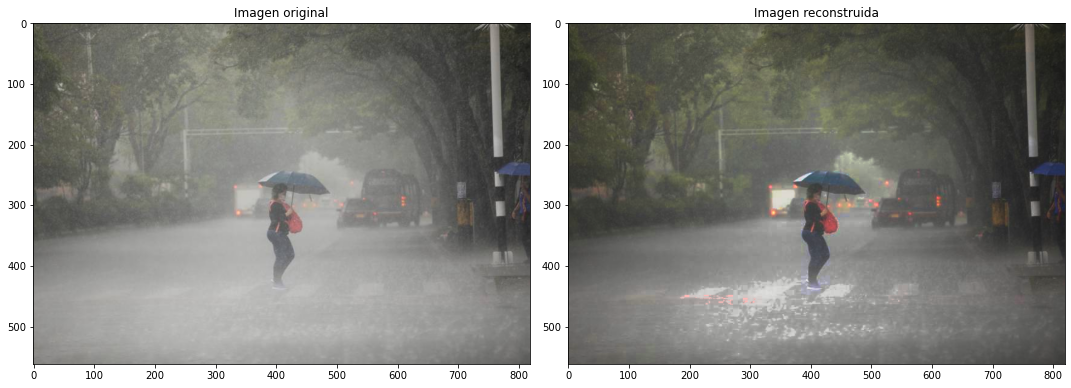

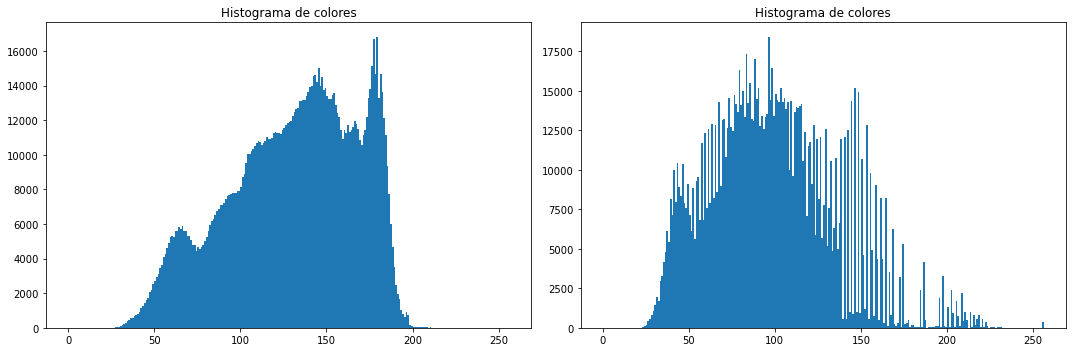

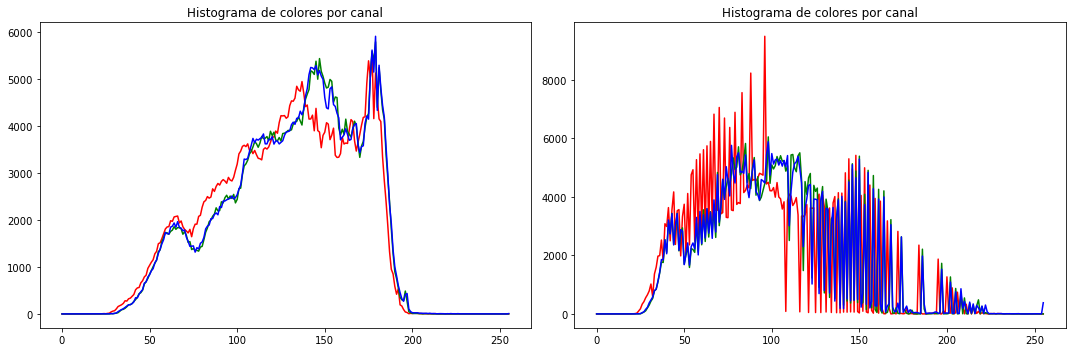

In [42]:
plot_results(HazeImg,OCImg)

<br><br>
<h3 style="color:teal"> MÉTODO ROY-CHAUDHURI</h3>

In [8]:
import scipy.io as io
import urllib.request
import matplotlib.pyplot as plt

In [9]:
def TransmissionRC(HazeImg, A):
    one_matrix = np.ones((HazeImg.shape[0],HazeImg.shape[1]))
    t_b = one_matrix-HazeImg[:, :, 0].astype(float)*(0.95/A[0])
    t_g = one_matrix-HazeImg[:, :, 1].astype(float)*(0.95/A[1])
    t_r = one_matrix-HazeImg[:, :, 2].astype(float)*(0.95/A[2])
    MaxVal = np.maximum(t_b, t_g, t_r)
    transmission = np.minimum(MaxVal, 1)
    return(transmission)

In [10]:
def contrastControllerRC(Image):
    grayscale = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    num=np.max(grayscale)-np.min(grayscale)
    den=int(np.max(grayscale))+int(np.min(grayscale))
    michelson=num/den
    for ch in range(len(Image.shape)):
        Image[:,:,ch]=Image[:,:,ch]*michelson
    return Image

In [11]:
def removeHazeRC(HazeImg,Transmission, A, delta, Regularize = False):
    epsilon = 0.0001
    A_contrast = [(255-x)/255 for x in A]
    A_contrast = [1-np.max(A_contrast)+x for x in A_contrast]
    Transmission = pow(np.maximum(abs(Transmission), epsilon), delta)
    HazeCorrectedImage = copy.deepcopy(HazeImg)
    for ch in range(len(HazeImg.shape)):
        A_matrix = np.ones((HazeImg.shape[0],HazeImg.shape[1]))    
        A_matrix = A_matrix*A[ch]
        temp=np.divide((HazeImg[:, :, ch]-A_matrix),np.maximum(Transmission, epsilon))+A_matrix
        temp = np.maximum(np.minimum(temp, 255), 0)
        HazeCorrectedImage[:, :, ch] = temp    
    return(HazeCorrectedImage) 

<h4>Evaluación</h4>

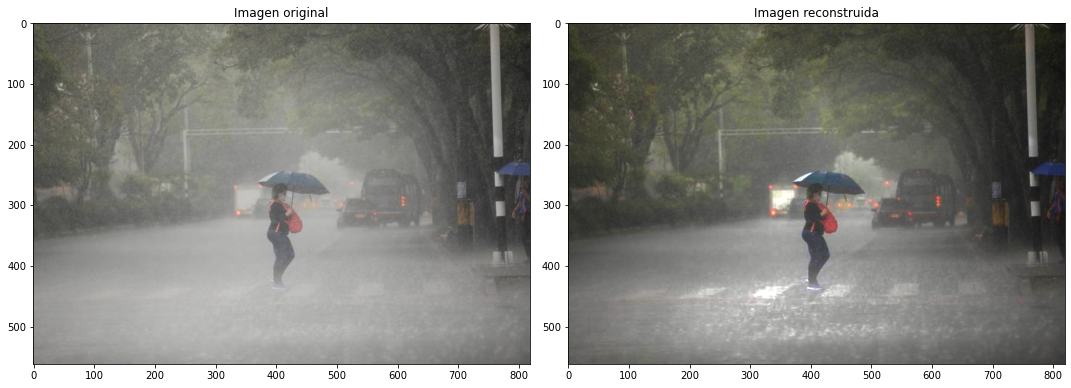

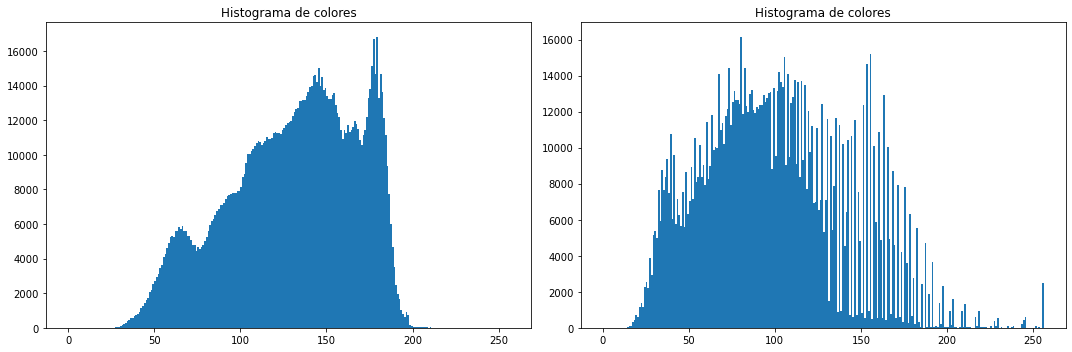

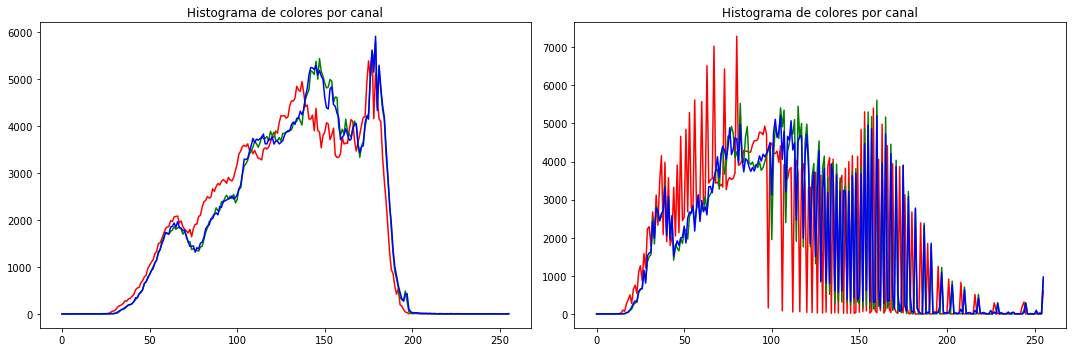

In [43]:
HazeImg = cv2.imread(nombre_im+"jpg")

# create the histogram plot, with three lines, one for
# each color

# Estimamos la luz del aire. 
# Podemos cambiar el tamaño del kernel que usamos para la erosión de la imagen
A = Airlight(HazeImg, windowSize_erode)
t = TransmissionRC(HazeImg,A)
# plt.imshow(t,cmap='gray')
# plt.show()
# print(t)
# El último parámetro es para definir si se regulariza la imagen o no
RCImg= removeHazeRC(HazeImg, t, A, 0.5, True)

plot_results(HazeImg,RCDehaze)

# cv2.imwrite("RCdehazed-"+nombre_im+"jpg",RCDehaze)

 <br><br>
 <h3 style="color:teal"> REDES NEURONALES CONVOLUCIONALES (CNN)</h3> 

<h4>Librerías</h4>

In [13]:
import tensorflow.compat.v1 as tf
from tensorflow.keras.layers import *
import os, shutil
import glob
import random
from PIL import Image
import cv2

<h4>Hiperparámetros</h4>

In [14]:
n_epochs = 10
batch_size = 8
learning_rate = 1e-4
weight_decay = 1e-4

<h4>Funciones auxiliares</h4>

In [15]:
def setup_data_paths(orig_images_path,hazy_images_path): 
    orig_image_paths = glob.glob(orig_images_path + "/*.jpg")
    n = len(orig_image_paths) 
    random.shuffle(orig_image_paths)
    train_keys = orig_image_paths[:int(0.90*n)]
    val_keys = orig_image_paths[int(0.90*n):]
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
  
    train_data = []
    val_data = []
  
    hazy_image_paths = glob.glob(hazy_images_path + "\*.jpg")
    for path in hazy_image_paths:        
        label = path.split('\\')[-1]
        orig_path = orig_images_path + "\\" + label.split('_')[0] + '_' + label.split('_')[1] + ".jpg"
        if(split_dict[orig_path] == 'train'):
          train_data.append([path,orig_path])
        else: val_data.append([path,orig_path])  
    return train_data, val_data

def load_image(X):
    X = tf.io.read_file(X)
    X = tf.image.decode_jpeg(X,channels=3)
    X = tf.image.resize(X,(480,640))
    X = X / 255.0
    return X

def showImage(x):
    x = np.asarray(x*255,dtype=np.int32)
    plt.figure()
    plt.imshow(x)
    plt.show()

In [16]:
def create_datasets(train_data,val_data,batch_size):  
    train_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in train_data]).map(lambda x: load_image(x))
    train_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in train_data]).map(lambda x: load_image(x))
    train_ds = tf.data.Dataset.zip((train_ds_hazy,train_ds_orig)).shuffle(100).repeat().batch(batch_size)

    val_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in val_data]).map(lambda x: load_image(x))
    val_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in val_data]).map(lambda x: load_image(x))
    val_ds = tf.data.Dataset.zip((val_ds_hazy,val_ds_orig)).shuffle(100).repeat().batch(batch_size)

    iterator = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(train_ds),tf.compat.v1.data.get_output_shapes(train_ds));
  
    train_init_op = iterator.make_initializer(train_ds);
    val_init_op = iterator.make_initializer(val_ds);
  
    return train_init_op, val_init_op, iterator


<h4>Diseño de la Red Neuronal Convolucional</h4>

In [17]:
def haze_net(X):  
    conv1 = Conv2D(3,1,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(X)
    conv2 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(conv1)
    concat1 = tf.concat([conv1,conv2],axis=-1)
  
    conv3 = Conv2D(3,5,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat1)
    concat2 = tf.concat([conv2,conv3],axis=-1)
  
    conv4 = Conv2D(3,7,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4],axis=-1)
  
    conv5 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat3)
    K = conv5
  
    output = ReLU(max_value=1.0)(tf.math.multiply(K,X) - K + 1.0)
    #output = output / 255.0
  
    return output

In [18]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
np.random.seed(9999)
tf.compat.v1.reset_default_graph()
train_data, val_data = setup_data_paths(os.getcwd()+"/data/orig_images",
                                        os.getcwd()+"/data/hazy_images")
train_init_op, val_init_op, iterator = create_datasets(train_data,val_data,batch_size);
next_element = iterator.get_next();

X = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
Y = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
dehazed_X = haze_net(X)

loss = tf.reduce_mean(tf.square(dehazed_X-Y));
optimizer = tf.train.AdamOptimizer(learning_rate);
trainable_variables = tf.trainable_variables();
gradients_and_vars = optimizer.compute_gradients(loss,trainable_variables);
clipped_gradients = [(tf.clip_by_norm(gradient,0.1),var) for gradient,var in gradients_and_vars];
optimizer = optimizer.apply_gradients(gradients_and_vars);

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.


<h4>Evaluación</h4>

In [19]:
tf.reset_default_graph()
train_data, val_data = setup_data_paths(os.getcwd()+"/data/orig_images",
                                        os.getcwd()+"/data/hazy_images")
train_init_op, val_init_op, iterator = create_datasets(train_data,val_data,batch_size);
next_element = iterator.get_next();

X = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
Y = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
dehazed_X = haze_net(X)

loss = tf.reduce_mean(tf.square(dehazed_X-Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
trainable_variables = tf.trainable_variables()
gradients_and_vars = optimizer.compute_gradients(loss,trainable_variables)
clipped_gradients = [(tf.clip_by_norm(gradient,0.1),var) for gradient,var in gradients_and_vars]
optimizer = optimizer.apply_gradients(gradients_and_vars)

INFO:tensorflow:Restoring parameters from C:\Users\Joluc\Documents\Jorge\UNAL\2022-2\Numerico\image-dehazing/models/model_checkpoint_7.ckpt


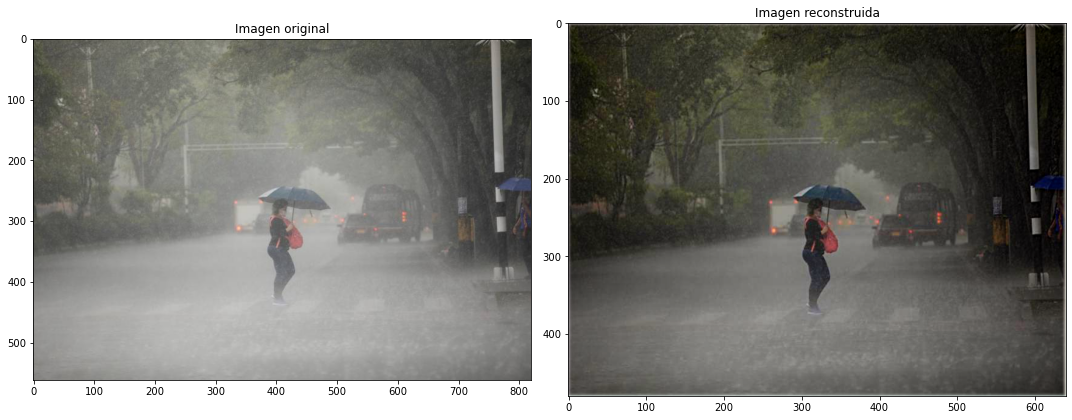

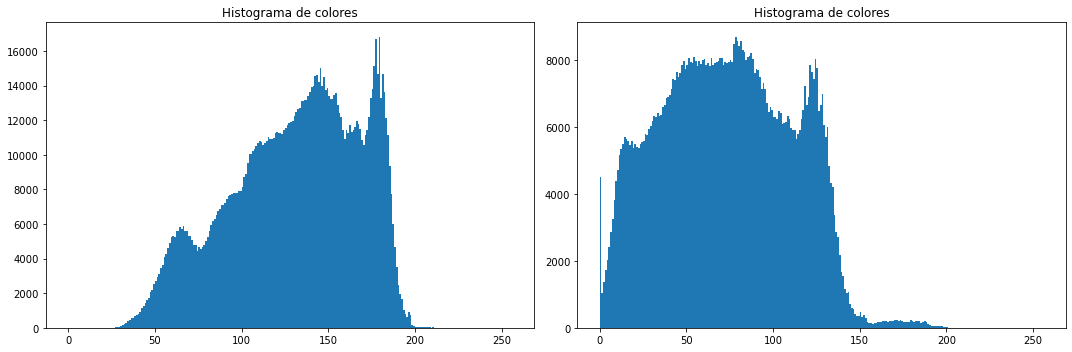

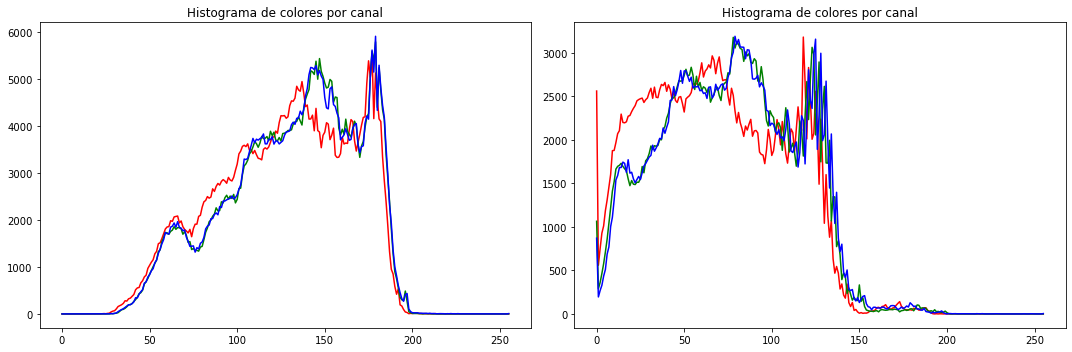

In [44]:
import matplotlib as mpl

def evaluarCNN():
    saver = tf.train.Saver();
    train_data, val_data = setup_data_paths(os.getcwd()+"/data/orig_images",
                                            os.getcwd()+"/data/hazy_images");

    test_input_folder = os.getcwd()+"/test_images";
    test_output_folder = os.getcwd()+"/dehazed_test_images";

    if not os.path.exists(test_output_folder):
      os.mkdir(test_output_folder);

    file_types = ['jpeg','jpg'];

    with tf.Session() as sess:
        saver.restore(sess,os.getcwd()+'/models/model_checkpoint_7.ckpt');
        test_image_paths = []
        for file_type in file_types:
            test_image_paths.extend(glob.glob(test_input_folder+"/*."+file_type));


        for path in test_image_paths:
            image_label = path.split(test_input_folder)[-1][1:];
            if nombre_im!=image_label[:-3]:
                continue
            image = Image.open(path)
            image = image.resize((640, 480))
            image = np.asarray(image) / 255.0
            image = image.reshape((1,) + image.shape)
            dehazed_image = sess.run(dehazed_X,feed_dict={X:image,Y:image});

            dehazed_image = np.asarray(dehazed_image[0] * 255,dtype=np.uint8)
            mpl.image.imsave(test_output_folder + "/" + 'dehazed_' + image_label, dehazed_image)
            #Para guardar la imagen en la carpeta principal

            mpl.image.imsave("CNNdehazed-"+nombre_im+"png", dehazed_image)
            HazeImg = cv2.imread(path)
            HazeCorrectedImg = cv2.imread("CNNdehazed-"+nombre_im+"png")
        return HazeCorrectedImg
            
CNNImg = evaluarCNN()
plot_results(HazeImg,CNNImg)

 <br><br>
 <h3 style="color:teal; display:inline"> MÉTODO YJN</h3><p style="color:teal; display:inline">(Yessica-Jorge-Nicolás)</p> 
 
Este es el método que proponemos basándonos en los resultados analizados en las 3 aproximaciones previas. El método que tomamos como base es el método de Roy-Chaudhuri y le agregamos una función de regularización para lograr un mejor contraste y suavida en la imagen final. Esta regularización la hacemos aplicando la transformada rápida discreta de Fourier y luego su inversa.

In [22]:
def TransmissionYJN(HazeImg, A):
    one_matrix = np.ones((HazeImg.shape[0],HazeImg.shape[1]))
    t_b = one_matrix-HazeImg[:, :, 0].astype(float)*(0.95/A[0])
    t_g = one_matrix-HazeImg[:, :, 1].astype(float)*(0.95/A[1])
    t_r = one_matrix-HazeImg[:, :, 2].astype(float)*(0.95/A[2])
    MaxVal = np.maximum(t_b, t_g, t_r)
    transmission = np.minimum(MaxVal, 1)
    return(transmission)

In [23]:
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist

In [24]:
def regularizationYJN(image):
    HazeCorrectedImage = copy.deepcopy(image)
    transformed_channels = []
    for i in range(3):
        rgb_fft = np.fft.fftshift(np.fft.fft2((image[:, :, i])))
        rgb_fft[:225, 235:237] = 1
        rgb_fft[-225:,235:237] = 1
        HazeCorrectedImage[:,:,i]=abs(np.fft.ifft2(rgb_fft))
    return HazeCorrectedImage
    

In [30]:
def removeHazeYJN(HazeImg,Transmission, A, delta):
    epsilon = 0.0001
    A_contrast = [(255-x)/255 for x in A]
    A_contrast = [1-np.max(A_contrast)+x for x in A_contrast]
    Transmission = pow(np.maximum(abs(Transmission), epsilon), delta)
    HazeCorrectedImage = copy.deepcopy(HazeImg)
    for ch in range(len(HazeImg.shape)):
        A_matrix = np.ones((HazeImg.shape[0],HazeImg.shape[1]))    
        A_matrix = A_matrix*A[ch]
        temp=np.divide((HazeImg[:, :, ch]-A_matrix),np.maximum(Transmission, epsilon))+A_matrix
        temp = np.maximum(np.minimum(temp, 255), 0)
        HazeCorrectedImage[:, :, ch] = temp
    RegularizedImage = regularizationYJN(HazeCorrectedImage)
    return(RegularizedImage) 

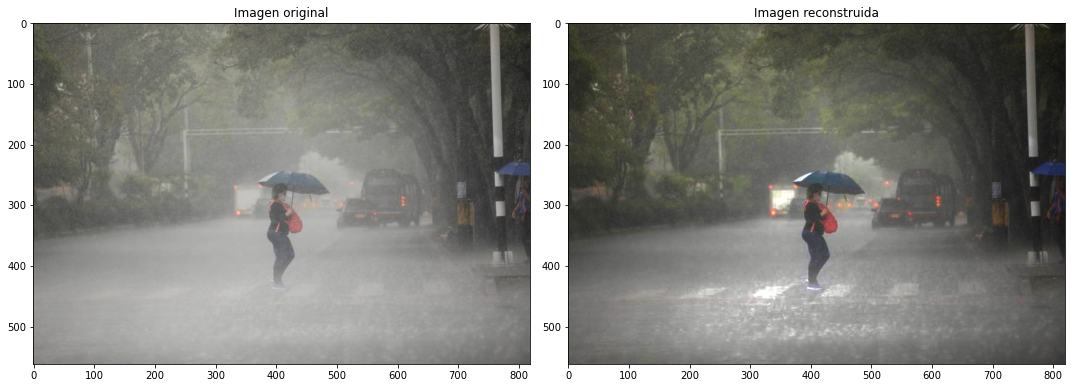

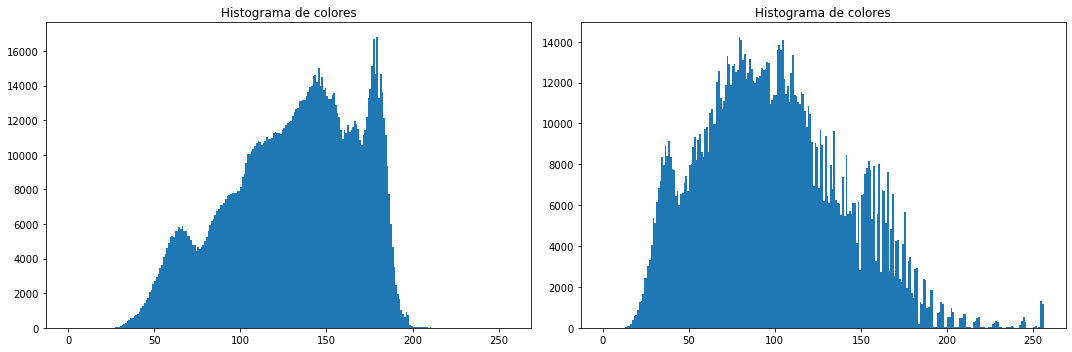

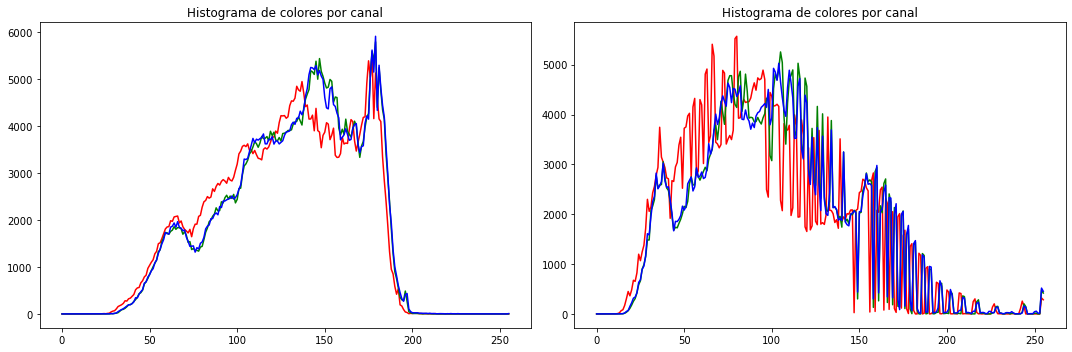

In [45]:
A = Airlight(HazeImg, windowSize_erode)
t = TransmissionRC(HazeImg,A)
YJNImg = removeHazeYJN(HazeImg, t, A, 0.5)
plot_results(HazeImg,YJNDehaze);
# cv2.imwrite("YJNdehazed-"+nombre_im+"jpg",YJNDehaze)

<br><br>
<h2 style="color:darkblue">COMPARACIÓN DE RESULTADOS</h2>
<br>
<h3 style="color:teal">TIEMPO</h3> 

In [32]:
import time
from tabulate import tabulate

def execTime():
    # Optimización Convexa
    times=[]
    start_time = time.time()
    OCImg = removeHaze(HazeImg, t, A, 0.5, False);
    finish_time = time.time() - start_time
    times.append(finish_time)

    # Método Roy-Chaudhuri
    start_time = time.time()
    RCImg = removeHazeRC(HazeImg, t, A, 0.5, True);
    finish_time = time.time() - start_time
    times.append(finish_time)

    # CNN
    start_time = time.time()
    CNNImg = evaluarCNN();
    finish_time = time.time() - start_time
    times.append(finish_time)

    # Método YJN
    start_time = time.time()
    YJNImg = removeHazeYJN(HazeImg, t, A, 0.5);
    finish_time = time.time() - start_time
    times.append(finish_time)
    return times

<br>
<h3 style="color:teal">CONSTRASTE</h3> 

In [62]:
def contrastes():
    contrasts=[]  
    
    # Foto Original
    min = int(np.min(HazeImg))
    max = int(np.max(HazeImg))
    contrast = (max-min)/(max+min)
    contrasts.append(contrast)
    
    
    # Optimización convexa
    min = int(np.min(OCImg))
    max = int(np.max(OCImg))
    contrast = (max-min)/(max+min)
    contrasts.append(contrast)
    
    # Método Roy-Chaudhuri
    min = int(np.min(RCImg))
    max = int(np.max(RCImg))
    contrast = (max-min)/(max+min)
    contrasts.append(contrast)
    
    # CNN
    min = int(np.min(CNNImg))
    max = int(np.max(CNNImg))
    contrast = (max-min)/(max+min)
    contrasts.append(contrast)
    
    # Método YJN
    min = int(np.min(YJNImg))
    max = int(np.max(YJNImg))
    contrast = (max-min)/(max+min)
    contrasts.append(contrast)
    
    return contrasts

<br>
<h3 style="color:teal">VARIACIÓN TOTAL</h3> 

In [81]:
def variaciones():
    variaciones=[[],[],[]]
    # Foto Original
    for ch, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            HazeImg[:, :, ch], bins=256, range=(0, 256)
        )
        variaciones[ch].append(np.var(histogram))   
    
    # Optimización convexa
    for ch, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            OCImg[:, :, ch], bins=256, range=(0, 256)
        )
        variaciones[ch].append(np.var(histogram))
    
    # Método Roy-Chaudhuri
    for ch, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            RCImg[:, :, ch], bins=256, range=(0, 256)
        )
        variaciones[ch].append(np.var(histogram))
        
    # CNN
    for ch, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            CNNImg[:, :, ch], bins=256, range=(0, 256)
        )
        variaciones[ch].append(np.var(histogram))
    
    # Método YJN
    for ch, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            YJNImg[:, :, ch], bins=256, range=(0, 256)
        )
        variaciones[ch].append(np.var(histogram))
    return variaciones

<br>
<h3 style="color:teal">CALIDAD DE LA IMAGEN</h3> 

In [21]:
def plot_results_ext(HazeImg, HazeCorrectedImg, RegularizedImg):
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,15))
    axes.ravel()
    rgb_img_original = cv2.cvtColor(HazeImg, cv2.COLOR_BGR2RGB)
    rgb_img_dehazed = cv2.cvtColor(HazeCorrectedImg, cv2.COLOR_BGR2RGB)
    rgb_img_regularized = cv2.cvtColor(RegularizedImg, cv2.COLOR_BGR2RGB)
    axes[0].imshow(rgb_img_original)
    axes[0].title.set_text("Original")
    axes[1].imshow(rgb_img_dehazed)
    axes[1].title.set_text("Método Roy-Chaudhuri")
    axes[2].imshow(rgb_img_regularized)
    axes[2].title.set_text("Método YJN")
    fig.tight_layout()
    plt.show()

    fig1, axes1 = plt.subplots(nrows=1, ncols=3,figsize=(15,4))
    axes1[0].title.set_text("Histograma de colores")
    axes1[0].hist(HazeImg.ravel(),256,[0,256])
    axes1[1].title.set_text("Histograma de colores")
    axes1[1].hist(HazeCorrectedImg.ravel(),256,[0,256])
    axes1[2].title.set_text("Histograma de colores")
    axes1[2].hist(RegularizedImg.ravel(),256,[0,256])
    fig1.tight_layout()

    fig2, axes2 = plt.subplots(nrows=1, ncols=3,figsize=(15,4))

    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            HazeImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[0].plot(bin_edges[0:-1], histogram, color=color)
    fig2.tight_layout()
    axes2[0].title.set_text("Histograma de colores por canal");    
    axes2[1].title.set_text("Histograma de colores por canal");
    axes2[2].title.set_text("Histograma de colores por canal");

    # fig2.tight_layout()
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            HazeCorrectedImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[1].plot(bin_edges[0:-1], histogram, color=color)

    fig2.tight_layout()
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            RegularizedImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[2].plot(bin_edges[0:-1], histogram, color=color)
    fig2.tight_layout()
    plt.title("Histograma de colores por canal");


# Referencias

https://github.com/Utkarsh-Deshmukh/Single-Image-Dehazing-Python/blob/master/src/removeHaze.py

https://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Meng_Efficient_Image_Dehazing_2013_ICCV_paper.pdf

https://www.researchgate.net/publication/307516271_Convex_optimization_for_fast_image_dehazing 

https://www.researchgate.net/publication/221110862_Fast_Visibility_Restoration_from_a_Single_Color_or_Gray_Level_Image

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8323906/